<a href="https://colab.research.google.com/github/RodrigodeFeo/8DTS/blob/main/Plataforma_Azure_Content_Safety_Exemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloud Cognitive Environments - Plataforma Azure

Os serviços no Azure sempre são compostos por 2 chaves, `CHAVE 1` e `CHAVE 2`, utilizadas para quando for necessário gerar novas você tem uma a mais de segurança. Além disso, tem um endpoint de acesso (ou `Chave de Extremidade`), da qual podemos interagir com o serviço diretamente via API Restful.

Também é comum utilizarmos bibliotecas que tornam o acesso ao endpoint mais simplificado.


Nota: Se houver atualização da versão que impeça a utilização, de alguma atividade, a mesma pode ser postergada e/ou substituída.


# Setup

Na Azure os serviços utilizam bibliotecas separadas, portanto elas serão instaladas a medida que aplicamos.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import datetime, json, os, time, uuid, random
import requests
import json
import cv2
from PIL import Image, ImageDraw

# Azure Content Safety

Serviço responsável por avaliar segurança de conteúdos com o objetivo de evitar conteúdos abusivos e inapropriados em texto ou imagem de serem compartilhados por usuários.

Consulte a [documentação](https://azure.microsoft.com/en-us/products/ai-services/ai-content-safety) para mais detalhes de aplicações e nesta [referência](https://learn.microsoft.com/en-us/python/api/overview/azure/ai-contentsafety-readme?view=azure-python-preview) exemplos de utilizações.

## Requerimentos

Vamos utilizar a biblioteca ```azure-ai-contetsafety``` que permite acessar as APIs do serviço de uma forma mais simplificada.

In [ ]:
!pip install azure-ai-contentsafety

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.3/194.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.5 MB/s eta 0:00:00


Importação de bibliotecas para utilização.

In [ ]:
from azure.ai.contentsafety import ContentSafetyClient
from azure.core.exceptions import HttpResponseError
from azure.ai.contentsafety.models import AnalyzeTextOptions, TextCategory
from azure.core.credentials import AzureKeyCredential

In [ ]:
#@title Preenchimento do Endpoint e da chave
#@markdown Preencha abaixo o endpoint da tua API e da chave. <br/>
#@markdown Após preenchimento execute essa célula.   <br/>

content_safety_endpoint = "https://grupo.cognitiveservices.azure.com/"  #@param {type: "string"}
content_safety_key = "732dcd22842e4211ad344e670ac68ef4"  #@param {type: "string"}

#@markdown ---


## Análise de texto

Busca por conteúdos de ódio, auto lesão, sexual e violência a partir de textos, associando severidade a cada detecção de modo a ponderar cada tipo de de conteúdo encontrado.

In [ ]:
# Credencial para autenticação do serviço
content_safety_credential = AzureKeyCredential(content_safety_key)

# Criação do cliente para interação com o serviço
content_safety_client = ContentSafetyClient(content_safety_endpoint, content_safety_credential)

# Texto a ser analisado
texto = "Você é um bobão. Deveria tirar a própria vida."

# Exemplo neutro
#texto = "Nada demais acontece por aqui, devido as instituições de segurança e política."

# Carregando a requisição com as categorias
# Podemos selecionar quais categorias e incluir no parâmetro categories=[TextCategory.HATE, TextCategory.SELF_HARM]
request_content = AnalyzeTextOptions(text=texto)

response = content_safety_client.analyze_text(request_content)

print(response)

{'blocklistsMatch': [], 'categoriesAnalysis': [{'category': 'Hate', 'severity': 2}, {'category': 'SelfHarm', 'severity': 4}, {'category': 'Sexual', 'severity': 0}, {'category': 'Violence', 'severity': 0}]}


In [ ]:
response

{'blocklistsMatch': [], 'categoriesAnalysis': [{'category': 'Hate', 'severity': 2}, {'category': 'SelfHarm', 'severity': 4}, {'category': 'Sexual', 'severity': 0}, {'category': 'Violence', 'severity': 0}]}

In [ ]:
response['categoriesAnalysis']

[{'category': 'Hate', 'severity': 2},
 {'category': 'SelfHarm', 'severity': 4},
 {'category': 'Sexual', 'severity': 0},
 {'category': 'Violence', 'severity': 0}]

In [ ]:
response_hate_result_severity = response.get('categoriesAnalysis')[0]["severity"]
response_self_harm_result_severity = response.get('categoriesAnalysis')[1]["severity"]
response_sexual_result_severity = response.get('categoriesAnalysis')[2]["severity"]
response_violence_result_severity = response.get('categoriesAnalysis')[3]["severity"]

In [ ]:
print("Hate severity: ", response_hate_result_severity, "SelfHarm severity: ", response_self_harm_result_severity)

Hate severity:  2 SelfHarm severity:  4


## Análise de imagem

Análise de dos mesmos grupos de segurança encontrados em texto para imagens.

Importação das bibliotecas utilizadas.

In [ ]:
from azure.ai.contentsafety.models import AnalyzeImageOptions, ImageData

Vamos analisar uma imagem da nuvem:

In [ ]:
!gsutil cp gs://ds-publico/BI/gru.jpg .

Copying gs://ds-publico/BI/gru.jpg...
/ [1 files][ 21.0 KiB/ 21.0 KiB]                                                
Operation completed over 1 objects/21.0 KiB.                                     


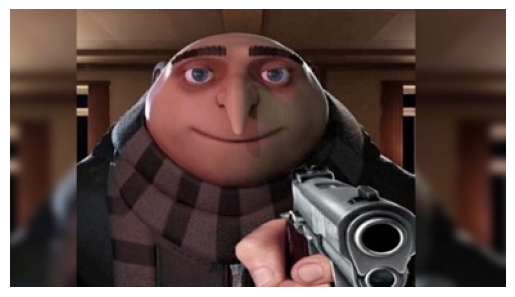

In [ ]:
caminho_imagem = "gru.jpg"

img = mpimg.imread(caminho_imagem)
imgplot = plt.imshow(img)

plt.axis('off')
plt.show()

Podemos utilizar o cliente já criado no exemplo anterior.

In [ ]:
# criando a requisição com a imagem em formato binário
with open(caminho_imagem, "rb") as file:
  request = AnalyzeImageOptions(image=ImageData(content=file.read()))

In [ ]:
# Enviando a requisição para análise
resultado = content_safety_client.analyze_image(request)

resultado

{'categoriesAnalysis': [{'category': 'Hate', 'severity': 0}, {'category': 'SelfHarm', 'severity': 0}, {'category': 'Sexual', 'severity': 0}, {'category': 'Violence', 'severity': 2}]}

In [ ]:
resposta_hate_result_severity = resultado.get('categoriesAnalysis')[0]["severity"]
resposta_self_harm_result_severity = resultado.get('categoriesAnalysis')[1]["severity"]
resposta_sexual_result_severity = resultado.get('categoriesAnalysis')[2]["severity"]
resposta_violence_result_severity = resultado.get('categoriesAnalysis')[3]["severity"]

In [ ]:
if resposta_hate_result_severity:
  print("Hate severity: ", resposta_hate_result_severity)
if resposta_self_harm_result_severity:
  print("SelfHarm severity: ", resposta_self_harm_result_severity)
if resposta_sexual_result_severity:
  print("Sexual severity: ", resposta_sexual_result_severity)
if resposta_violence_result_severity:
  print("Violence severity: ", resposta_violence_result_severity)

Violence severity:  2


## Blocos de listas customizados

Quando há palavras e termos que podem ser disfarçados trocando letras por caracteres similares, exemplo i por 1, A por 4 ou ocultações.

Nestes casos podemos criar listas de palavras para incluir estes termos.

Importação das bibliotecas

In [ ]:
from azure.ai.contentsafety.models import AnalyzeTextOptions
from azure.ai.contentsafety.models import TextBlockItemInfo
from azure.ai.contentsafety.models import AddBlockItemsOptions

ImportError: cannot import name 'TextBlockItemInfo' from 'azure.ai.contentsafety.models' (/usr/local/lib/python3.10/dist-packages/azure/ai/contentsafety/models/__init__.py)

In [ ]:
# Nome da lista de bloqueio
blocklist_name = "BlocklistPtBr"
#TextBlockItemInfoblocklist_name = "BlocklistPtBr"
# Descrição da lista de bloqueio
blocklist_description = "Blocklist Portuguese-Brazilian"

content_safety_client.delete_text_blocklist(blocklist_name) # Zera a lista
blocklist = content_safety_client.create_or_update_text_blocklist(blocklist_name=blocklist_name, resource={"description": blocklist_description})
blocklist

In [ ]:
block_items = [TextBlockItemInfo(text="mort#"),
               TextBlockItemInfo(text="su1c1d10"),
               TextBlockItemInfo(text="esT#pr0")]

resultado = content_safety_client.add_block_items(blocklist_name=blocklist_name, body=AddBlockItemsOptions(block_items=block_items))

resultado

In [ ]:
block_items = [TextBlockItemInfo(text="mort3")]

resultado = content_safety_client.add_block_items(blocklist_name=blocklist_name, body=AddBlockItemsOptions(block_items=block_items))

resultado

In [ ]:
texto = "Pessoas podem gostar de mort3 e fazer su1c1d10."

resultado = content_safety_client.analyze_text(AnalyzeTextOptions(text=texto, blocklist_names=[blocklist_name]))
resultado

In [ ]:
for match_result in resultado.blocklists_match_results:
  print(f"Block item was hit in text, Offset={match_result.offset}, Length={match_result.length}.")
  print(f"BlocklistName: {match_result.blocklist_name}, BlockItemId: {match_result.block_item_id}, BlockItemText: {match_result.block_item_text}")